## Цели и задачи

**Цели проекта**: 
* Применить полученные во время обучения знания по обработке и анализу данных на практике;
* Усовершенствовать навыки работы со статистическими методами.

**Задачи проекта**:
* Провести обработку данных;
* Провести корреляционный анализ;
* Провести анализ номинативных и категориальных переменных;
* Подготовить данные для обучения модели;
* Выдвинуть гипотезы.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import scipy.stats as ss
from dython import nominal
from sklearn.impute import SimpleImputer

stud_math = pd.read_csv('stud_math.csv')

In [2]:
display(stud_math.head(10))
stud_math.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,...,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,...,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,...,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,...,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,...,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,...,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,...,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,...,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,...,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,...,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

## Классификация признаков

1. **Числовые**: age, abcences, score;
2. **Категориальные**:
    * **Категориальные (бинарные)**: sex, address, famsize, Pstatus, schoolsup, famsup, paid, activities, nursery, higher, internet, romantic;
    * **Категориальные (оценочные)**: Medu, Fedu, Mjob, Fjob, reason, guardian, traveltime, studytime, failures, famrel, freetime, goout, health.

## Функции

In [3]:
# Информация о колонке

def col_info(column):
    print(column.value_counts(dropna=False))
    print('Percent of missing values:', round(
        (column.isnull().sum()/395) * 100, 2))

# Строим боксплоты


def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='score', data=stud_math, ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


# Тест Стьюдента

def get_stat_dif(data, column):
    cols = data.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        p_value = ttest_ind(data.loc[data.loc[:, column] == comb[0], 'score'],
                            data.loc[data.loc[:, column] == comb[1], 'score']).pvalue
        if p_value <= 0.05/len(combinations_all):
            print('Найдены статистически значимые различия для признака {}'
                  .format(column))
            break

# Тест Стьюдента для dummies


def stat_dif_for_dummies(column):
    dummies = pd.get_dummies(stud_math[column]).rename(
        columns=lambda x: '{}_'.format(column) + str(x))
    dummies['score'] = stud_math['score']
    columns_for_print = dummies.columns[:-1]
    for column in columns_for_print:
        get_stat_dif(dummies, column)


# Замена NaN для числовых переменных

def replace_missing_values_numeric(stud_math, numeric_features):
    for i in numeric_features:
        imputer = SimpleImputer(missing_values=np.nan, strategy="median")
        imputer.fit(stud_math[[i]])
        stud_math[i] = imputer.transform(stud_math[[i]])


# Замена NaN для категориальных переменных

def replace_missing_values_categorical(stud_math, categorical_features):
    for i in categorical_features:
        imputer = SimpleImputer(missing_values=np.nan,
                                strategy="most_frequent")
        imputer.fit(stud_math[[i]])
        stud_math[i] = imputer.transform(stud_math[[i]])

## Первичная обработка данных и удаление выбросов

### **school**

In [4]:
col_info(stud_math.school)

GP    349
MS     46
Name: school, dtype: int64
Percent of missing values: 0.0


### **sex**

In [5]:
col_info(stud_math.sex)

F    208
M    187
Name: sex, dtype: int64
Percent of missing values: 0.0


### **age**

In [6]:
col_info(stud_math.age)

16    104
17     98
18     82
15     82
19     24
20      3
22      1
21      1
Name: age, dtype: int64
Percent of missing values: 0.0


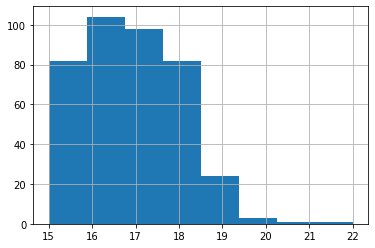

In [7]:
stud_math.age.hist(bins=8)

Выбросы отсутствуют.

### **address**

In [8]:
col_info(stud_math.address)

U      295
R       83
NaN     17
Name: address, dtype: int64
Percent of missing values: 4.3


### **famsize**

In [9]:
col_info(stud_math.famsize)

GT3    261
LE3    107
NaN     27
Name: famsize, dtype: int64
Percent of missing values: 6.84


### **Pstatus**

In [10]:
col_info(stud_math.Pstatus)

T      314
NaN     45
A       36
Name: Pstatus, dtype: int64
Percent of missing values: 11.39


### **Medu**

In [11]:
col_info(stud_math.Medu)

4.0    131
2.0    102
3.0     97
1.0     59
0.0      3
NaN      3
Name: Medu, dtype: int64
Percent of missing values: 0.76


### **Fedu**

In [12]:
col_info(stud_math.Fedu)

2.0     106
3.0      96
4.0      88
1.0      78
NaN      24
0.0       2
40.0      1
Name: Fedu, dtype: int64
Percent of missing values: 6.08


В данных присутствует выброс:
* Возможно, значение 40 является ошибкой в записи 4, в таком случае его следует заменить на 4:
* Возможно, значение 40 никак не связано с 4, в таком случае его следует заменить на медианное значение.

Я воспользуюсь первым вариантом:

In [13]:
stud_math.Fedu = stud_math.Fedu.apply(lambda x: 4.0 if x == 40.0 else x)

### **Mjob**

In [14]:
col_info(stud_math.Mjob)

other       133
services     98
at_home      58
teacher      55
health       32
NaN          19
Name: Mjob, dtype: int64
Percent of missing values: 4.81


### **Fjob**

In [15]:
col_info(stud_math.Fjob)

other       197
services    102
NaN          36
teacher      29
at_home      16
health       15
Name: Fjob, dtype: int64
Percent of missing values: 9.11


### **reason**

In [16]:
col_info(stud_math.reason)

course        137
home          104
reputation    103
other          34
NaN            17
Name: reason, dtype: int64
Percent of missing values: 4.3


### **guardian**

In [17]:
col_info(stud_math.guardian)

mother    250
father     86
NaN        31
other      28
Name: guardian, dtype: int64
Percent of missing values: 7.85


### **traveltime**

In [18]:
col_info(stud_math.traveltime)

1.0    242
2.0     96
NaN     28
3.0     22
4.0      7
Name: traveltime, dtype: int64
Percent of missing values: 7.09


### **studytime**

In [19]:
col_info(stud_math.studytime)

2.0    194
1.0    103
3.0     64
4.0     27
NaN      7
Name: studytime, dtype: int64
Percent of missing values: 1.77


### **studytime, granular**

In [20]:
col_info(stud_math['studytime, granular'])

-6.0     194
-3.0     103
-9.0      64
-12.0     27
 NaN       7
Name: studytime, granular, dtype: int64
Percent of missing values: 1.77


Проверим, коррелируют ли между собой **studytime** и **studytime, granular**:

In [21]:
stud_math['studytime, granular'].corr(stud_math['studytime'])

-1.0

Полная обратная корреляция! Один из признаков можно удалить (я удалю studytime, granular).

### **failures**

In [22]:
col_info(stud_math.failures)

0.0    293
1.0     49
NaN     22
2.0     16
3.0     15
Name: failures, dtype: int64
Percent of missing values: 5.57


### **schoolsup**

In [23]:
col_info(stud_math.schoolsup)

no     335
yes     51
NaN      9
Name: schoolsup, dtype: int64
Percent of missing values: 2.28


### **famsup**

In [24]:
col_info(stud_math.famsup)

yes    219
no     137
NaN     39
Name: famsup, dtype: int64
Percent of missing values: 9.87


### **paid**

In [25]:
col_info(stud_math.paid)

no     200
yes    155
NaN     40
Name: paid, dtype: int64
Percent of missing values: 10.13


### **activities**

In [26]:
col_info(stud_math.activities)

yes    195
no     186
NaN     14
Name: activities, dtype: int64
Percent of missing values: 3.54


### **nursery**

In [27]:
col_info(stud_math.nursery)

yes    300
no      79
NaN     16
Name: nursery, dtype: int64
Percent of missing values: 4.05


### **higher**

In [28]:
col_info(stud_math.higher)

yes    356
NaN     20
no      19
Name: higher, dtype: int64
Percent of missing values: 5.06


### **internet**

In [29]:
col_info(stud_math.internet)

yes    305
no      56
NaN     34
Name: internet, dtype: int64
Percent of missing values: 8.61


### **romantic**

In [30]:
col_info(stud_math.romantic)

no     240
yes    124
NaN     31
Name: romantic, dtype: int64
Percent of missing values: 7.85


### **famrel**

In [31]:
col_info(stud_math.famrel)

 4.0    182
 5.0     99
 3.0     62
 NaN     27
 2.0     17
 1.0      7
-1.0      1
Name: famrel, dtype: int64
Percent of missing values: 6.84


В данных присутствует выброс: -1. Заменим его на единицу:

In [32]:
stud_math.famrel = stud_math.famrel.apply(lambda x: 1.0 if x == -1.0 else x)

### **freetime**

In [33]:
col_info(stud_math.freetime)

3.0    153
4.0    112
2.0     63
5.0     38
1.0     18
NaN     11
Name: freetime, dtype: int64
Percent of missing values: 2.78


### **goout**

In [34]:
col_info(stud_math.goout)

3.0    127
2.0    101
4.0     84
5.0     52
1.0     23
NaN      8
Name: goout, dtype: int64
Percent of missing values: 2.03


### **health**

In [35]:
col_info(stud_math.health)

5.0    138
3.0     89
4.0     63
1.0     47
2.0     43
NaN     15
Name: health, dtype: int64
Percent of missing values: 3.8


### **absences**

In [36]:
col_info(stud_math.absences)

0.0      111
2.0       60
4.0       53
6.0       31
8.0       21
10.0      17
12.0      12
NaN       12
14.0      12
3.0        8
16.0       7
7.0        6
5.0        5
18.0       5
20.0       4
1.0        3
22.0       3
9.0        3
13.0       2
15.0       2
11.0       2
25.0       1
54.0       1
385.0      1
26.0       1
56.0       1
24.0       1
212.0      1
21.0       1
75.0       1
30.0       1
19.0       1
38.0       1
40.0       1
23.0       1
17.0       1
28.0       1
Name: absences, dtype: int64
Percent of missing values: 3.04


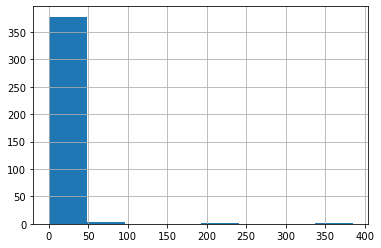

In [37]:
stud_math.absences.hist(bins=8)

Очевидно, в данных присутствуют выбросы. Отфильтруем их:

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


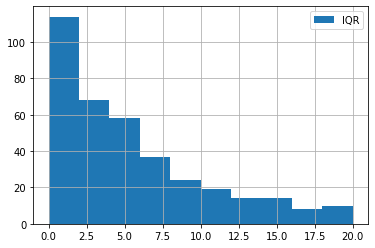

In [38]:
median = stud_math.absences.median()
IQR = stud_math.absences.quantile(0.75) - stud_math.absences.quantile(0.25)
perc25 = stud_math.absences.quantile(0.25)
perc75 = stud_math.absences.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75),
      "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
stud_math.absences.loc[stud_math.absences.between(
    perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(label='IQR')
plt.legend()

In [39]:
stud_math = stud_math.loc[stud_math.absences.between(
    perc25 - 1.5*IQR, perc75 + 1.5*IQR)]

### **score**

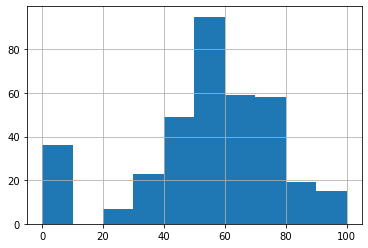

In [40]:
stud_math.score.hist()

In [41]:
col_info(stud_math.score)

50.0     53
55.0     42
0.0      36
75.0     31
65.0     30
60.0     29
70.0     27
40.0     26
45.0     23
80.0     16
30.0     14
90.0      9
35.0      9
25.0      7
95.0      5
NaN       5
85.0      3
100.0     1
Name: score, dtype: int64
Percent of missing values: 1.27


## Заполнение NaN

Заменим медианным значением все NaN в числовых переменных и наиболее часто встречающимся - в категориальных:

In [42]:
numeric_features = ['age', 'absences', 'score']

In [43]:
categorical_features = ['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'studytime, granular', 'famrel', 'freetime', 'goout', 'health', 'school', 'sex',
                        'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']

In [44]:
replace_missing_values_numeric(stud_math, numeric_features)

In [45]:
replace_missing_values_categorical(stud_math, categorical_features)

## Корелляционный анализ числовых признаков

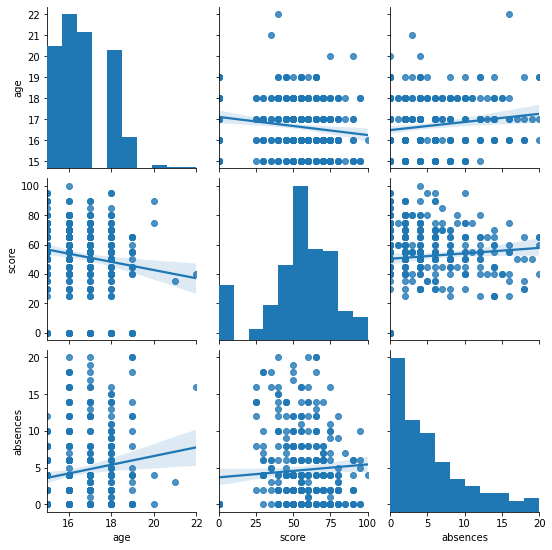

In [46]:
sns.pairplot(stud_math.loc[:, ['age', 'score', 'absences']], kind='reg')

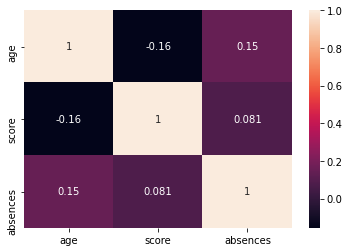

In [47]:
corr = stud_math.loc[:, ['age', 'score', 'absences']].corr()
sns.heatmap(corr, annot=True)

На основании коэффициентов корреляции можно предположить следующее:
1. С возрастом оценки обучающихся ухудшаются, а количество пропусков увеличивается
2. Количество пропусков практически не влияет на итоговую оценку (но исключать его я не буду на всякий случай)

## Анализ категориальных признаков

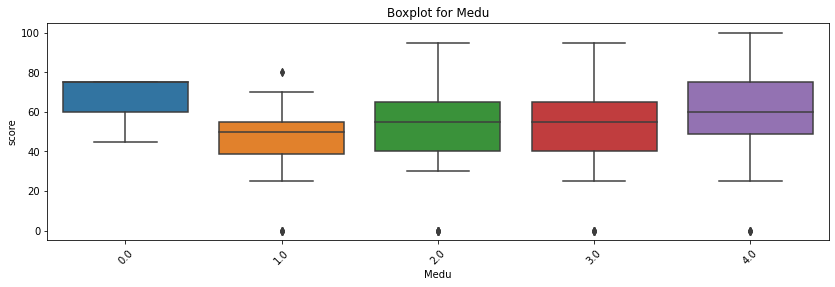

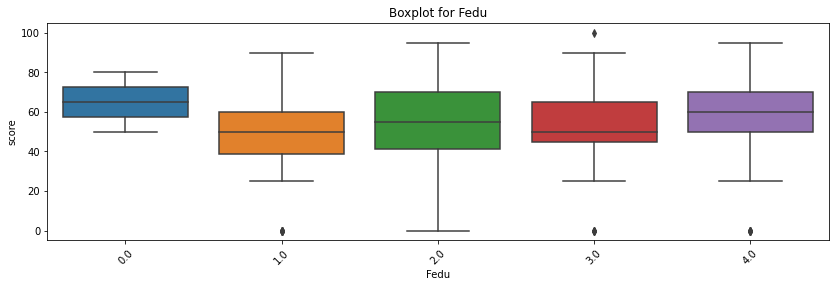

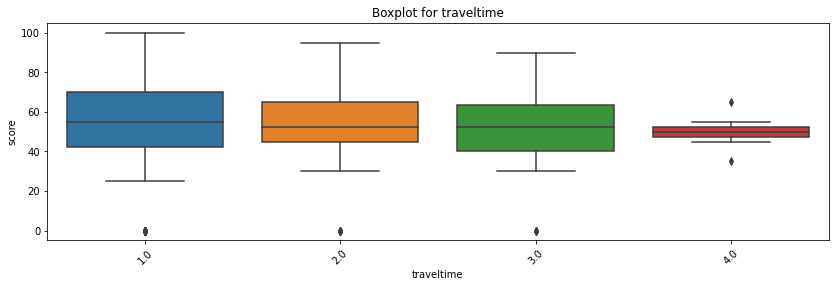

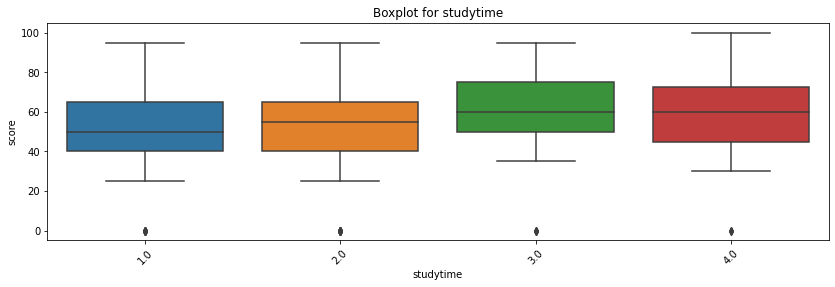

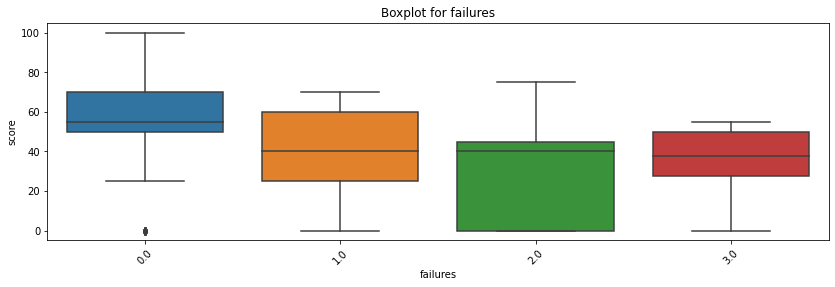

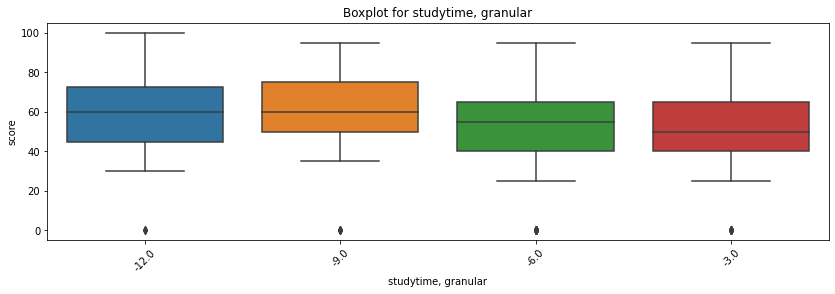

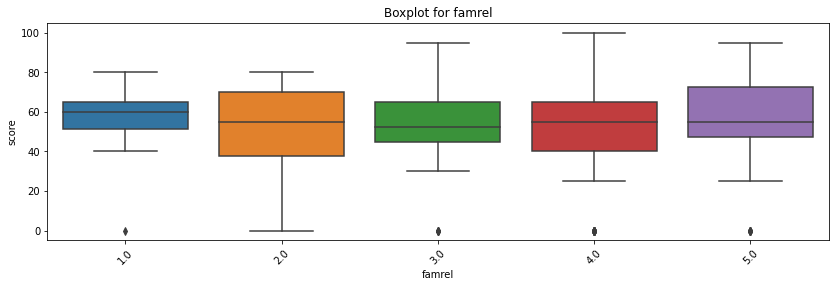

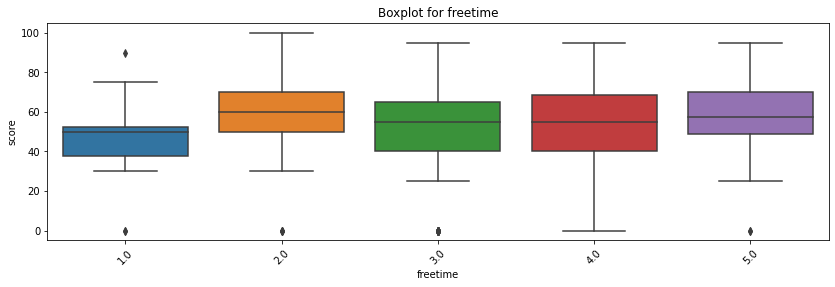

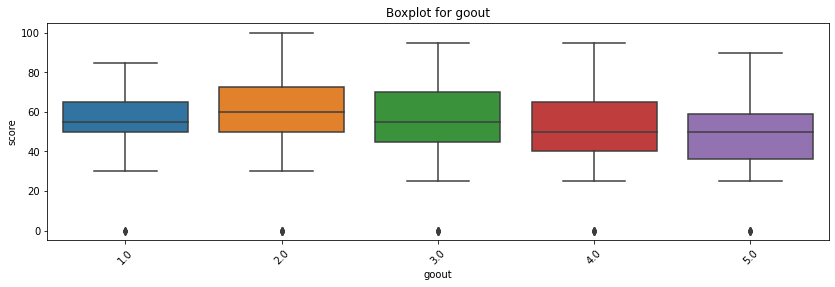

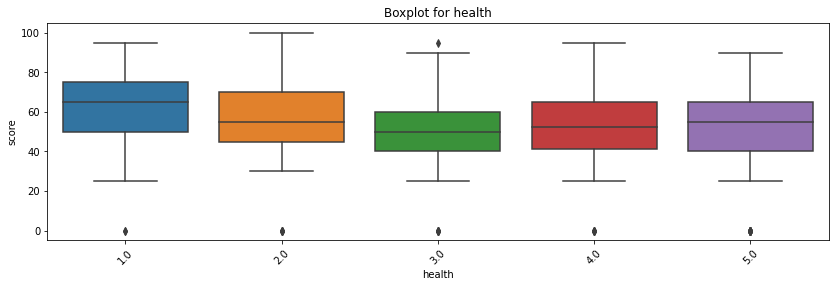

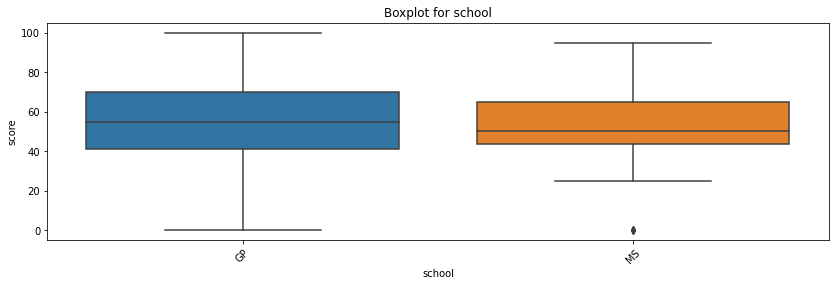

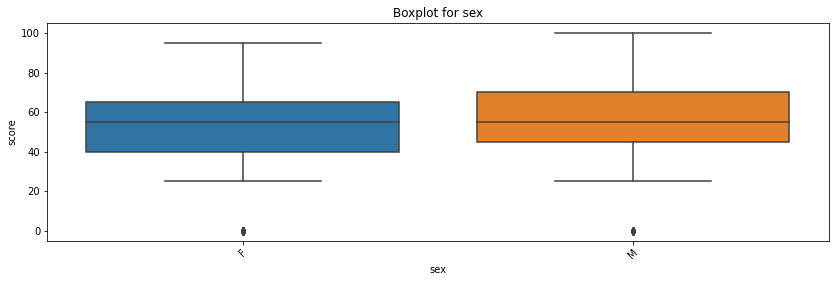

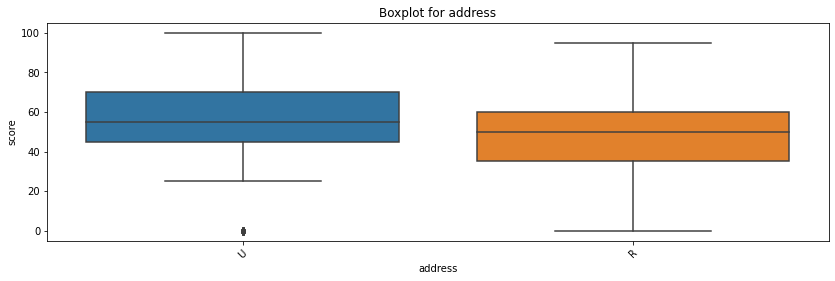

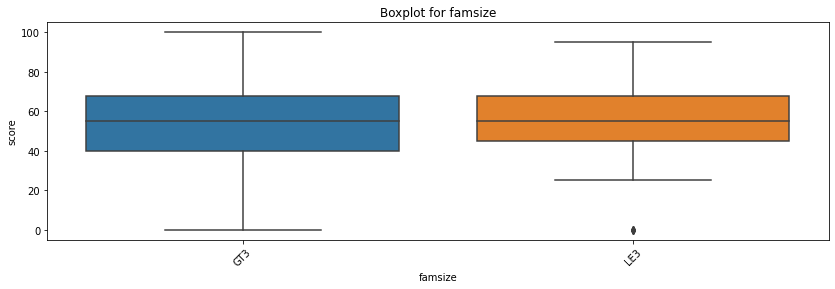

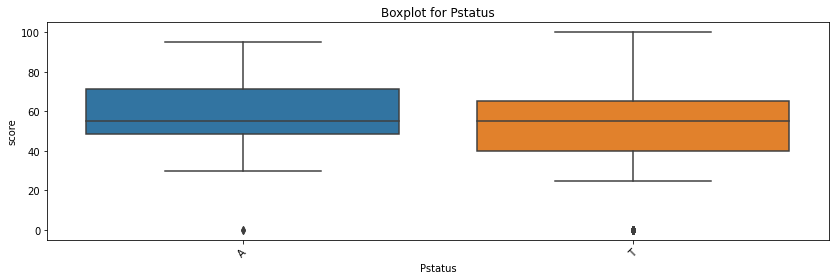

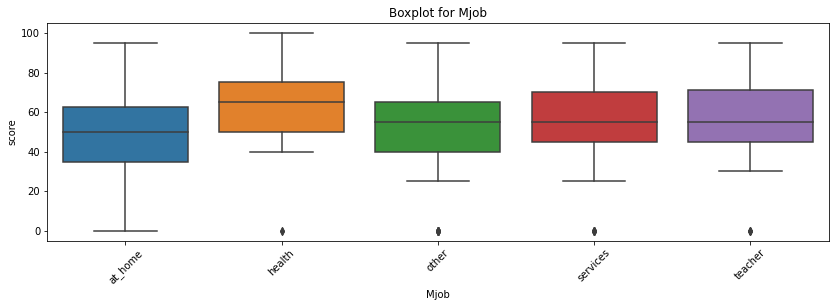

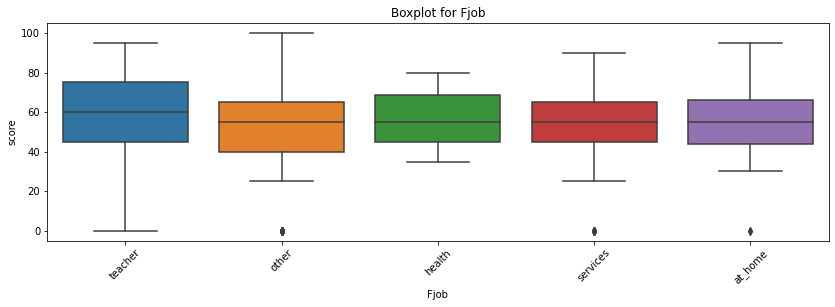

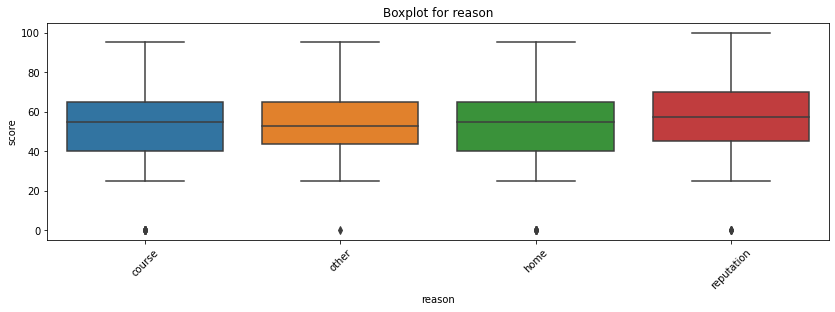

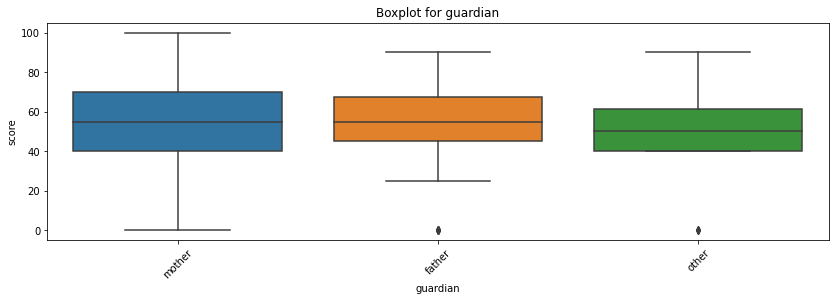

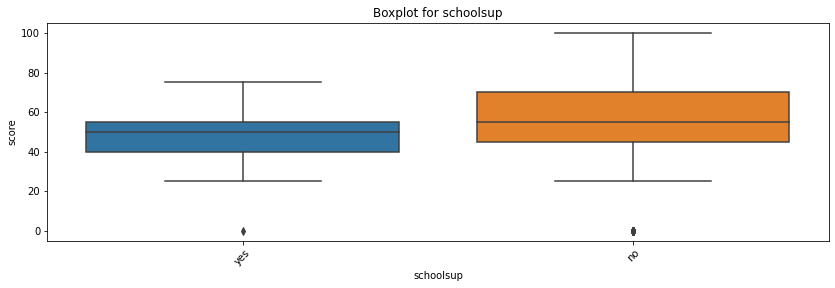

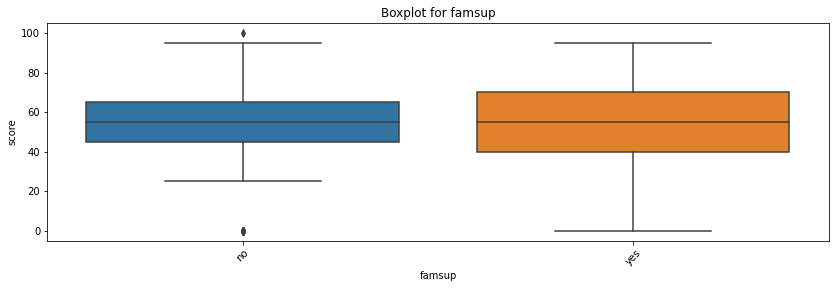

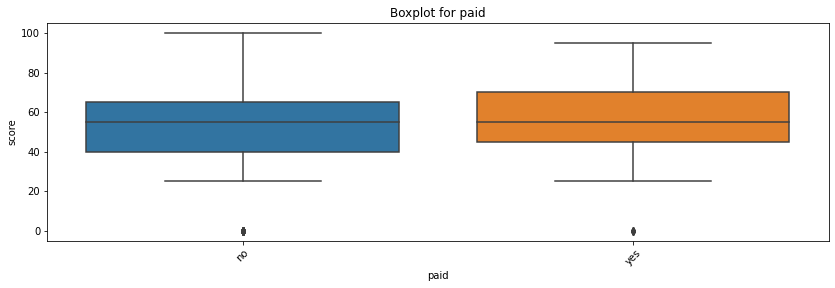

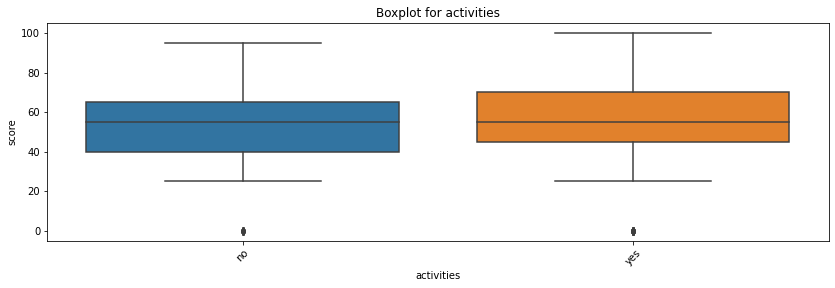

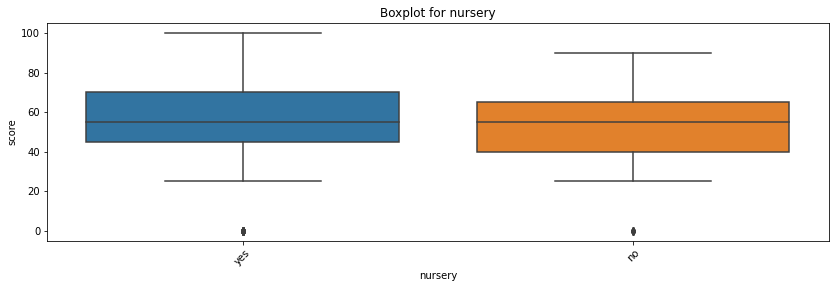

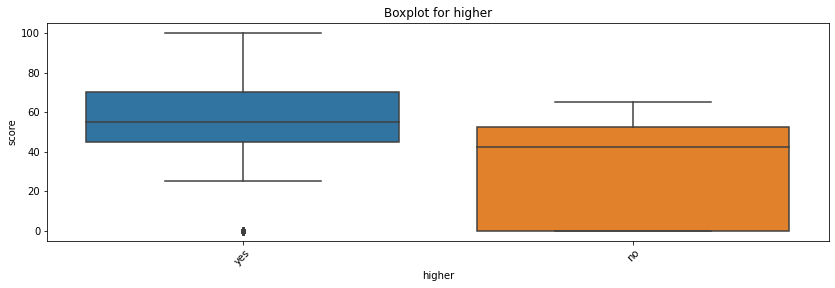

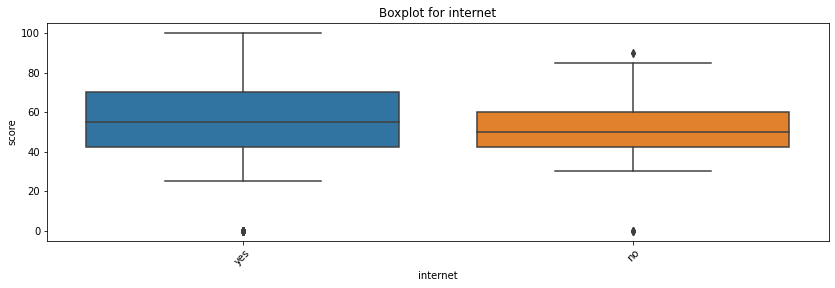

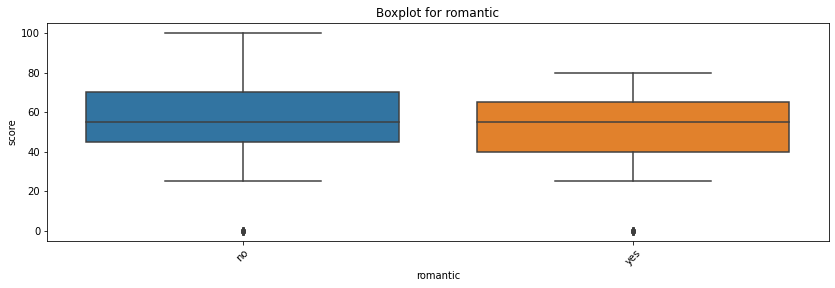

In [48]:
for i in categorical_features:
    get_boxplot(i)

Из боксплотов лично мне видно только то, что желание получить высшее образование влияет на оценку.

Проведем тест Стьюдента сначала для признаков:

In [49]:
for column in categorical_features:
    get_stat_dif(stud_math, column)

Найдены статистически значимые различия для признака Medu
Найдены статистически значимые различия для признака failures
Найдены статистически значимые различия для признака sex
Найдены статистически значимые различия для признака address
Найдены статистически значимые различия для признака Mjob
Найдены статистически значимые различия для признака paid
Найдены статистически значимые различия для признака higher
Найдены статистически значимые различия для признака romantic


А потом для значений признаков, в которых не обнаружилось статистически значимых различий:

In [50]:
features = ['Fedu', 'traveltime', 'studytime', 'famrel', 'freetime', 'goout', 'health', 'school', 'famsize',
            'Pstatus', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'activities', 'nursery', 'internet']

In [51]:
for column in features:
    stat_dif_for_dummies(column)

Найдены статистически значимые различия для признака Fedu_1.0
Найдены статистически значимые различия для признака studytime_3.0
Найдены статистически значимые различия для признака goout_5.0
Найдены статистически значимые различия для признака health_1.0


### Таким образом, мы получили признаки, влияющие на переменную score:

In [52]:
relatable_features = ['Medu', 'failures', 'sex', 'address', 'Mjob', 'paid', 'higher', 'romantic',
                      'Fedu', 'studytime', 'goout', 'health', 'age', 'absences', 'score']

In [53]:
df_for_model = stud_math.loc[:, relatable_features].reset_index(drop=True)

In [54]:
df_for_model.head(10)

,Medu,failures,sex,address,Mjob,paid,higher,romantic,Fedu,studytime,goout,health,age,absences,score
0,4.0,0.0,F,U,at_home,no,yes,no,4.0,2.0,4.0,3.0,18.0,6.0,30.0
1,1.0,0.0,F,U,at_home,no,yes,no,1.0,2.0,3.0,3.0,17.0,4.0,30.0
2,1.0,3.0,F,U,at_home,no,yes,no,1.0,2.0,2.0,3.0,15.0,10.0,50.0
3,4.0,0.0,F,U,health,yes,yes,yes,2.0,3.0,2.0,5.0,15.0,2.0,75.0
4,3.0,0.0,F,U,other,yes,yes,no,3.0,2.0,2.0,5.0,16.0,4.0,50.0
5,4.0,0.0,M,U,services,yes,yes,no,3.0,2.0,2.0,5.0,16.0,10.0,75.0
6,2.0,0.0,M,U,other,no,yes,no,2.0,2.0,4.0,3.0,16.0,0.0,55.0
7,4.0,0.0,F,U,other,no,yes,no,4.0,2.0,4.0,1.0,17.0,6.0,30.0
8,3.0,0.0,M,U,services,yes,yes,no,2.0,2.0,2.0,1.0,15.0,0.0,95.0
9,3.0,0.0,M,U,other,yes,yes,no,4.0,2.0,1.0,5.0,15.0,0.0,75.0


## Лирическое отступление

Для корреляционного анализа категориальных переменных и числовых (простите) я буду использовать библиотеку [dython](https://pypi.org/project/dython/). Она позволяет использовать корреляцию Крамера, [Uncertainty coefficient](https://en.wikipedia.org/wiki/Uncertainty_coefficient) и другие методы статистики.

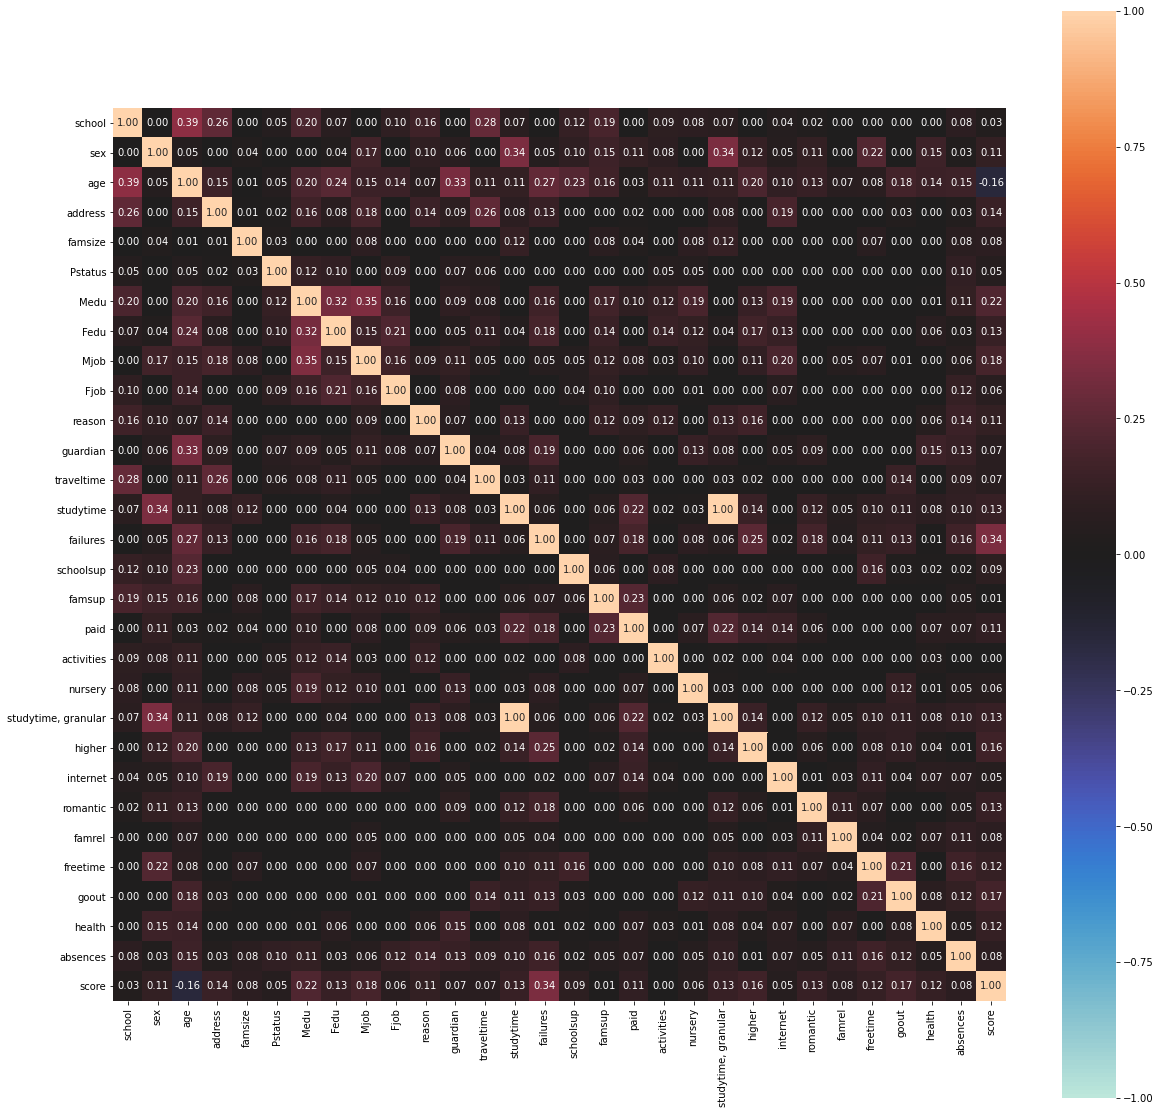

{'corr':                        school       sex       age   address   famsize  \
 school               1.000000  0.000000  0.385867  0.264450  0.000000   
 sex                  0.000000  1.000000  0.046462  0.000000  0.036151   
 age                  0.385867  0.046462  1.000000  0.152055  0.005257   
 address              0.264450  0.000000  0.152055  1.000000  0.013484   
 famsize              0.000000  0.036151  0.005257  0.013484  1.000000   
 Pstatus              0.046249  0.000000  0.045717  0.016222  0.033153   
 Medu                 0.202776  0.000000  0.199953  0.159914  0.000000   
 Fedu                 0.066140  0.038680  0.237755  0.077859  0.000000   
 Mjob                 0.000000  0.169994  0.145416  0.182805  0.083257   
 Fjob                 0.096569  0.000000  0.141028  0.000000  0.000000   
 reason               0.160381  0.099609  0.073654  0.143851  0.000000   
 guardian             0.000000  0.062535  0.330236  0.088093  0.000000   
 traveltime           0.278384

In [55]:
nominal.associations(
    stud_math, nominal_columns=categorical_features, figsize=(20, 20))

На основании проведенных корреляционных анализов я бы оставила признаки, у которых коэффициент корреляции со score больше 0,1:

In [56]:
relatable_features_test = ['sex', 'age', 'address', 'Medu', 'Fedu', 'Mjob', 'reason', 'studytime',
                           'failures', 'paid', 'higher', 'romantic', 'freetime', 'goout', 'health', 'absences', 'score']

In [57]:
df_for_model_test = stud_math.loc[:,
                                  relatable_features_test].reset_index(drop=True)

In [58]:
df_for_model_test.head(10)

,sex,age,address,Medu,Fedu,Mjob,reason,studytime,failures,paid,higher,romantic,freetime,goout,health,absences,score
0,F,18.0,U,4.0,4.0,at_home,course,2.0,0.0,no,yes,no,3.0,4.0,3.0,6.0,30.0
1,F,17.0,U,1.0,1.0,at_home,course,2.0,0.0,no,yes,no,3.0,3.0,3.0,4.0,30.0
2,F,15.0,U,1.0,1.0,at_home,other,2.0,3.0,no,yes,no,3.0,2.0,3.0,10.0,50.0
3,F,15.0,U,4.0,2.0,health,home,3.0,0.0,yes,yes,yes,2.0,2.0,5.0,2.0,75.0
4,F,16.0,U,3.0,3.0,other,home,2.0,0.0,yes,yes,no,3.0,2.0,5.0,4.0,50.0
5,M,16.0,U,4.0,3.0,services,reputation,2.0,0.0,yes,yes,no,4.0,2.0,5.0,10.0,75.0
6,M,16.0,U,2.0,2.0,other,home,2.0,0.0,no,yes,no,4.0,4.0,3.0,0.0,55.0
7,F,17.0,U,4.0,4.0,other,home,2.0,0.0,no,yes,no,1.0,4.0,1.0,6.0,30.0
8,M,15.0,U,3.0,2.0,services,home,2.0,0.0,yes,yes,no,2.0,2.0,1.0,0.0,95.0
9,M,15.0,U,3.0,4.0,other,home,2.0,0.0,yes,yes,no,5.0,1.0,5.0,0.0,75.0


Добавилось три признака: Fedu, reason и freetime.